In [1]:
from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Activation, ZeroPadding2D, UpSampling2D, Conv2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def discriminator():
   start = Input(shape = (image_size,image_size,1))

   d1 = Conv2D(8, kernel_size=3, strides=2, input_shape=(image_size,image_size,1), padding="same")(start)
   d1 = LeakyReLU(alpha=0.2)(d1)

   d2 = Conv2D(16, kernel_size=3, strides=2, padding="same")(d1)
   d2 = ZeroPadding2D(padding=((0, 1), (0, 1)))(d2)
   d2 = LeakyReLU(alpha=0.2)(d2)

   d3 = Conv2D(32, kernel_size=3, strides=2, padding="same")(d2)
   d3 = LeakyReLU(alpha=0.2)(d3)

   d4 = Flatten()(d3)
   output = Dense(1, activation='sigmoid')(d4)

   return Model(start, output)


In [3]:
def generator(input_dim=32):
   noise = Input(shape=(input_dim,))

   g1 = Dense(7*7*32, activation="relu", input_dim=input_dim)(noise)
   g1 = Reshape((7, 7, 32))(g1)

   g2 = UpSampling2D()(g1)
   g2 = Conv2D(32, kernel_size=3, padding="same", activation="relu")(g2)

   g3 = UpSampling2D()(g2)
   g3 = Conv2D(16, kernel_size=3, padding="same", activation="relu")(g3)

   g4 = Conv2D(1, kernel_size=3, padding="same")(g3)
   img = Activation("tanh")(g4)

   return Model(noise, img)


In [4]:
def classifier():
    start = Input(shape = (image_size,image_size,1))

    c1 = Conv2D(8, kernel_size=3, strides=2, input_shape=(image_size,image_size,1), padding='same', activation='relu')(start)
    c1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(16, kernel_size=3, strides=2, input_shape=(image_size,image_size,1), padding='same', activation='relu')(c1)
    c2 = MaxPooling2D(pool_size=(2, 2))(c2)

    flat = Flatten()(c2)
    hidden1 = Dense(64, activation='relu')(flat)
    output = Dense(2, activation='softmax')(hidden1)

    return Model(inputs=start, outputs=output)

In [5]:
def obtain_dataset(selected_class, number_of_images):
  # load data from mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = x_train[y_train==selected_class][:int(number_of_images*(1-test_size)),:,:]
  y_train = y_train[y_train==selected_class][:int(number_of_images*(1-test_size))]
  x_test = x_test[y_test==selected_class][:int(number_of_images*test_size),:,:]
  y_test = y_test[y_test==selected_class][:int(number_of_images*test_size)]

  # Set data shape, type and groundtruth
  x_train = x_train.astype('float32').reshape(-1, image_size, image_size, 1)
  x_train /= 255

  x_test = x_test.astype('float32').reshape(-1, image_size, image_size, 1)
  x_test /= 255

  y_train = y_train.astype('uint8').reshape((-1,1))
  y_test = y_test.astype('uint8').reshape((-1,1))

  return x_train, y_train, x_test, y_test

In [6]:
def build_and_train_classifier(epochs, batch_size):
  # build a classifier named 'model'
  model = classifier()

  # compile 'model'
  optimizer_model = Adam(0.0001, 0.5)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_model, metrics=['accuracy'])

  # train the classifier
  history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.1)

  # test the classifier
  y_pred = model.predict(x_test)
  y_pred = y_pred.argmax(axis=-1)

  print('\nconfusion matrix:\n', confusion_matrix(y_test, y_pred))
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)

  plt.plot(fpr,tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  auc_ = auc(fpr, tpr)
  return auc_

In [7]:
def build_and_train_GAN(epochs, batch_size):

  # define hyper-parameter for GAN
  optimizer_GEN = Adam(0.0001, 0.5)
  optimizer_DIS = Adam(0.0004, 0.5)

  # build a discriminator named 'Dis'
  Dis = discriminator()

  # compile 'Dis'
  Dis.compile(loss='binary_crossentropy', optimizer=optimizer_DIS, metrics=['accuracy'])

  # build a generator named 'Gen' with input random_vector
  Gen = generator(random_vector)

  # Generator training route
  start = Input(shape=(random_vector,))
  fake_image = Gen(start)
  Dis.trainable = False
  decide = Dis(fake_image)
  comb_model = Model(start, decide)
  comb_model.compile(loss='binary_crossentropy', optimizer=optimizer_GEN)

  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  # Use train_on_batch instead of model.fit
  for epoch in range(epochs):
      count = 0
      for time in range(x_train_0.shape[0]//batch_size):
          # Get Real&Fake sample for discriminator from dataset&generator
          noise = np.random.normal(0, 1, (batch_size, random_vector))
          gen_images = Gen.predict(noise)
          train_images = x_train_0[count:count+batch_size, :, :, :]
          # Training Discriminator
          d_loss_real = Dis.train_on_batch(train_images, valid)
          d_loss_fake = Dis.train_on_batch(gen_images, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          # Training generator
          noise = np.random.normal(0, 1, (batch_size, random_vector))
          g_loss = comb_model.train_on_batch(noise, valid)

          print("%d-%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, time, d_loss[0], 100*d_loss[1], g_loss))

          count += batch_size

  return Gen

In [8]:
def create_fake_images(number_of_fake_images):
  fake_images = np.empty((0,image_size,image_size,1))
  for ni in range(number_of_fake_images):
    noise = np.random.normal(0, 1, (1,random_vector))
    temp = Gen.predict(noise)
    temp = 0.5 * temp + 0.5
    fake_images = np.append(fake_images,temp)

  return fake_images


In [9]:
# [1] Define the hyper-parameters
test_size = 0.1
image_size = 28
random_vector = 32

In [10]:
# [2] Obtain dataset '0' and '1' from mnist
x_train_0, y_train_0, x_test_0, y_test_0 = obtain_dataset(selected_class=0, number_of_images=100)
x_train_1, y_train_1, x_test_1, y_test_1 = obtain_dataset(selected_class=1, number_of_images=1000)
print("class 0: ", x_train_0.shape, x_test_0.shape, y_train_0.shape, y_test_0.shape)
print("class 1: ", x_train_1.shape, x_test_1.shape, y_train_1.shape, y_test_1.shape)

11490434/11490434 [==============================] - 0s 0us/step
class 0:  (90, 28, 28, 1) (10, 28, 28, 1) (90, 1) (10, 1)
class 1:  (900, 28, 28, 1) (100, 28, 28, 1) (900, 1) (100, 1)


In [11]:
# [3] Create imbalanced dataset by merging class '0' and '1'
x_train=np.concatenate((x_train_0, x_train_1))
x_test=np.concatenate((x_test_0, x_test_1))
y_train=np.concatenate((y_train_0, y_train_1))
y_test=np.concatenate((y_test_0, y_test_1))
print("merged 0 and 1 data: ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

merged 0 and 1 data:  (990, 28, 28, 1) (110, 28, 28, 1) (990, 1) (110, 1)


Epoch 1/5
28/28 [==============================] - 2s 23ms/step - loss: 0.6864 - accuracy: 0.5499 - val_loss: 0.6450 - val_accuracy: 0.9596
Epoch 2/5
28/28 [==============================] - 0s 9ms/step - loss: 0.6105 - accuracy: 0.8934 - val_loss: 0.5565 - val_accuracy: 1.0000
Epoch 3/5
28/28 [==============================] - 0s 6ms/step - loss: 0.5413 - accuracy: 0.8990 - val_loss: 0.4673 - val_accuracy: 1.0000
Epoch 4/5
28/28 [==============================] - 0s 6ms/step - loss: 0.4713 - accuracy: 0.8990 - val_loss: 0.3740 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 3ms/step

confusion matrix:
 [[  0  10]
 [  0 100]]


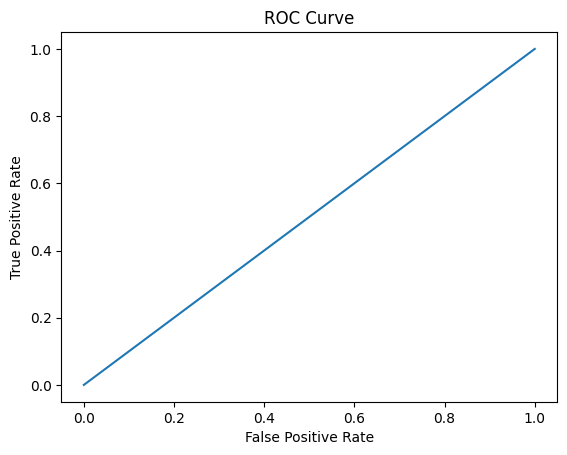

Area Under the Curve(AUC) from the imbalanced data: 0.5


In [12]:
# [4] Build, train, and test a classifier
# TODO: call function build_and_train_classifier with epoch 5 and batch size 32, print the output
# ...
result = build_and_train_classifier(5,32)
print("Area Under the Curve(AUC) from the imbalanced data:", result)

In [13]:
# [5] Build and train GAN
# TODO: call function build_and_train_GAN with epoch 20 and batch size 32, save the output to a variable named 'Gen'
# ...
Gen = build_and_train_GAN(20, 32)

1/1 [==============================] - 0s 203ms/step
0-0 [D loss: 0.683912, acc.: 59.38%] [G loss: 0.688540]
1/1 [==============================] - 0s 48ms/step
0-1 [D loss: 0.673052, acc.: 50.00%] [G loss: 0.687044]
1/1 [==============================] - 0s 54ms/step
1-0 [D loss: 0.669209, acc.: 54.69%] [G loss: 0.686072]
1/1 [==============================] - 0s 129ms/step
1-1 [D loss: 0.657366, acc.: 50.00%] [G loss: 0.684406]
1/1 [==============================] - 0s 118ms/step
2-0 [D loss: 0.655645, acc.: 50.00%] [G loss: 0.683528]
1/1 [==============================] - 0s 51ms/step
2-1 [D loss: 0.641895, acc.: 50.00%] [G loss: 0.679169]
1/1 [==============================] - 0s 54ms/step
3-0 [D loss: 0.644374, acc.: 50.00%] [G loss: 0.678024]
1/1 [==============================] - 0s 43ms/step
3-1 [D loss: 0.628805, acc.: 50.00%] [G loss: 0.673999]
1/1 [==============================] - 0s 49ms/step
4-0 [D loss: 0.632469, acc.: 50.00%] [G loss: 0.674052]
1/1 [====================

In [14]:
# [6] Create fake data for class '0'
number_of_fake_images = 900
# TODO: call function create_fake_images with given number of fake images, save the output to a variable named 'fake_images'
# ...
fake_images = create_fake_images(number_of_fake_images)
fake_images = fake_images.reshape((-1, image_size, image_size, 1))
print(fake_images.shape)

1/1 [==============================] - 0s 22ms/step
(900, 28, 28, 1)


In [15]:
# [7] Merge fake data with the original data
train_num = int(number_of_fake_images*(1-test_size))
test_num = int(number_of_fake_images*test_size)
x_train = np.concatenate((x_train, fake_images[:train_num,:,:]))
x_test = np.concatenate((x_test, fake_images[train_num:,:,:]))
y_train = np.concatenate((y_train, np.zeros(train_num).reshape((-1,1))))
y_test = np.concatenate((y_test, np.zeros(test_num).reshape((-1,1))))
print("final data: ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

final data:  (1800, 28, 28, 1) (200, 28, 28, 1) (1800, 1) (200, 1)


Epoch 1/5
51/51 [==============================] - 3s 17ms/step - loss: 0.6310 - accuracy: 0.5556 - val_loss: 0.7213 - val_accuracy: 0.0000e+00
Epoch 2/5
51/51 [==============================] - 1s 10ms/step - loss: 0.5689 - accuracy: 0.6488 - val_loss: 0.6713 - val_accuracy: 1.0000
Epoch 3/5
51/51 [==============================] - 0s 10ms/step - loss: 0.4878 - accuracy: 0.9444 - val_loss: 0.5746 - val_accuracy: 1.0000
Epoch 4/5
51/51 [==============================] - 0s 10ms/step - loss: 0.3889 - accuracy: 0.9451 - val_loss: 0.4372 - val_accuracy: 1.0000
Epoch 5/5
7/7 [==============================] - 0s 6ms/step

confusion matrix:
 [[100   0]
 [  0 100]]


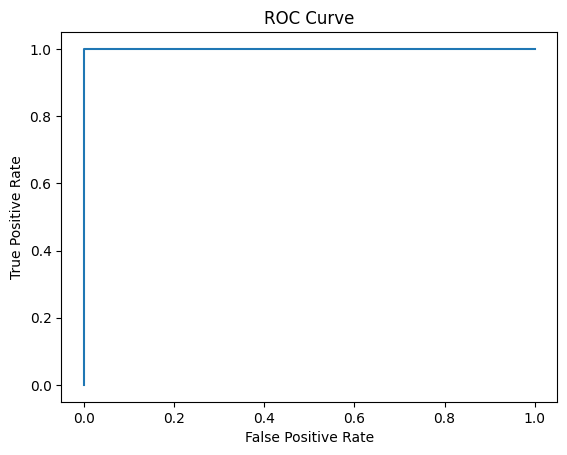

Area Under the Curve 1.0


In [16]:
# [8] Build, train, and test a classifier
# TODO: call function build_and_train_classifier with epoch 5 and batch size 32, print the output
# ...
final_output = build_and_train_classifier(5,32)
print("Area Under the Curve", final_output)